<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 12
# Student 1: Denise La Gordt Dillie
# Student 2: Andreea Maican
# Student 3: Sambhav Jain

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [ ]:
# # Change the following  line to the directory this notebook is (if using colab)
# # In case you do not know the path, open the file navigator on the left in colab
# # Find the folder containing this notebook, then press on the three dots --> copy path
# notebook_dir = "/content/drive/MyDrive/Colab Notebooks/"

In [ ]:
# # UNCOMMENT IF USING COLAB
# from google.colab import drive
# import requests
# drive.mount('/content/drive')
# import sys
# import os
# sys.path.insert(0, notebook_dir) 
# os.chdir(notebook_dir)
# symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
# crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
# r_s = requests.get(symco, allow_redirects=True)
# r_c = requests.get(crpt, allow_redirects=True)
# with open('symconv.py', 'wb') as f:
#     f.write(r_s.content)
# with open('carpet.py', 'wb') as f:
#     f.write(r_c.content)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

c:\.virtualenvs\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [ ]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

In [ ]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [ ]:
def loss_batch(model, loss_func, xb, yb, optimizer=None):
    yb = torch.argmax(yb, dim=1)

    assert yb.dim() <= 1, "Target tensor must have 0 or 1 dimensions"
    assert yb.numel() == len(xb), "Target tensor size must match input size"

    output = model(xb)
    loss = loss_func(output, yb.long())

    if optimizer is not None:
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.long())

    return loss.item(), corrects, len(xb)

In [ ]:
import matplotlib.pyplot as plt

def fit(epochs, model, loss_func, optimizer, train_dl, valid_dl, test_dl):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    test_losses = []
    test_accs = []

    for epoch in tqdm(range(epochs)):
        # Training process
        model.train()
        running_loss = 0.0
        running_corrects = 0
        sample_num = 0

        for xb, yb in train_dl:
            losses, corrects, nums = loss_batch(model, loss_func, xb, yb, optimizer)
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num += nums

        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num

        # Validation process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num = 0

            for xb, yb in valid_dl:
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num += nums

            val_loss = running_loss / sample_num
            val_acc = running_corrects.double() / sample_num

        # Testing process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num = 0

            for xb, yb in test_dl:
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num += nums

            test_loss = running_loss / sample_num
            test_acc = running_corrects.double() / sample_num

        # Print the results
        print(f'EPOCH: {epoch+1:0>{len(str(epochs))}}/{epochs}', end=' ')
        print(f'LOSS: {train_loss:.4f}', f'ACC: {train_acc:.4f} ', end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}', f'VAL-ACC: {val_acc:.4f} ', end=' ')
        print(f'TEST-LOSS: {test_loss:.4f}', f'TEST-ACC: {test_acc:.4f} ', end='\n')

        # Save losses and accuracies
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    # Plot losses and accuracies
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs+1), train_losses, 'r:', label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, 'g:', label='Validation Loss')
    plt.plot(range(1, epochs+1), test_losses, 'b:', label='Test Loss')
    plt.plot(range(1, epochs+1), train_accs, 'r', label='Train Accuracy')
    plt.plot(range(1, epochs+1), val_accs, 'g', label='Validation Accuracy')
    plt.plot(range(1, epochs+1), test_accs, 'b', label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss / Accuracy')
    plt.title('Loss and Accuracy vs. Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def get_data(train_ds, valid_ds, batch_size):
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(valid_ds, batch_size=batch_size * 2),
    )

In [ ]:
batch_size = 64
train_dl, valid_dl = get_data(train_dataset, val_dataset, batch_size)
test_dl = DataLoader(test_dataset, batch_size=batch_size * 2)

In [3]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [ ]:
model = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, kernel_size=3, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    nn.Dropout(0.2),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 3),
)

In [ ]:
from torch import optim

lr = 0.06
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs = 20
loss_func = F.cross_entropy

fit(epochs, model, loss_func, optimizer, train_dl, valid_dl, test_dl)

## Task 1: Question 5d

### Experiment 1
In this experiment, we change the number of convolutional filters in the model architecture. Convolutional filters are responsible for capturing different patterns and features from the input data. By altering the number of filters, we can assess the effect on the model's performance.

In [ ]:
# Experiment 1: Change the Number of Convolutional Filters
model_exp1 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 16, kernel_size=4, stride=4, rotation=4, reflection=False), # Change the number of filters to 16
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(16), # Adjust the batch normalization layer accordingly
    nn.Dropout(0.2),
    nn.Conv2d(16, 64, kernel_size=3, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    nn.Dropout(0.2),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 3),
)

optimizer_exp1 = optim.SGD(model_exp1.parameters(), lr=lr, momentum=0.9)

fit(epochs, model_exp1, loss_func, optimizer_exp1, train_dl, valid_dl, test_dl)

### Experiment 2
In this experiment, we change the activation function used in the model architecture. The activation function introduces non-linearity to the model, allowing it to learn complex patterns and make non-linear predictions. By altering the activation function, we can assess its effect on the model's performance.

In [ ]:
# Experiment 2: Change Activation Function
model_exp2 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, kernel_size=3, stride=3),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    nn.Dropout(0.2),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.LeakyReLU(inplace=True),  # Change activation function
    nn.Linear(100, 3),
)

optimizer_exp2 = optim.SGD(model_exp2.parameters(), lr=lr, momentum=0.9)

fit(epochs, model_exp2, loss_func, optimizer_exp2, train_dl, valid_dl, test_dl)

### Experiment 3
In this experiment, we change the learning rate used for training the model. The learning rate determines the step size at which the model updates its parameters during the optimization process. By adjusting the learning rate, we can explore its effect on the convergence speed and the overall performance of the model.

In [ ]:
# Experiment 3: Adjust Learning Rate
lr_exp3 = 0.01  # Change learning rate

model_exp3 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, kernel_size=3, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    nn.Dropout(0.2),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 3),
)

optimizer_exp3 = optim.SGD(model_exp3.parameters(), lr=lr_exp3, momentum=0.9)

fit(epochs, model_exp3, loss_func, optimizer_exp3, train_dl, valid_dl, test_dl)

# Task 2: Carpet Matching 

In [4]:
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

Carpet train shape: (15000, 1, 96, 60)
Label train shape: (15000,)
Ground truth test shape: (300,)
Query carpets shape: (300, 1, 96, 60)
Candidate carpets shape: (300, 4, 1, 96, 60)


In [5]:
from torch.utils.data.sampler import BatchSampler
import numpy as np
class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [6]:
class EmbeddingNet_Sym(nn.Module):
    def __init__(self):
        """CNN Builder."""
        super(EmbeddingNet_Sym, self).__init__()

        self.front_layer = nn.Sequential(
                sc.Slice(rotation=4, reflection=False),
                sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
                nn.ReLU(inplace=True),
                sc.SymmetryPool(),
                nn.BatchNorm2d(32),
                nn.Dropout(0.2),
                nn.Conv2d(32, 64, kernel_size=3, stride=3),
                nn.ReLU(inplace=True),
                sc.Slice(rotation=4, reflection=False),
                sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
                nn.ReLU(inplace=True),
                sc.SymmetryPool(),
                nn.BatchNorm2d(10),
                nn.Dropout(0.2),
                Lambda(lambda x: x.view(x.size(0), -1)),
                nn.Linear(40, 100),
                nn.ReLU(inplace=True),
            )

        self.last_layer = nn.Linear(100, 200)

    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.front_layer(x)
        x = self.last_layer(x)
        return x
    
    def get_embedding(self, x):
        return self.forward(x)

In [7]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        image = self.X[index]
        label = self.y[index]

        # Convert the image and label to torch tensors
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, label
    
dataset = CustomDataset(X, y)

In [8]:
N = 200  # Number of classes in each mini-batch
m = 5   # Number of samples from each class

train_batch_sampler = BalancedBatchSampler(y, n_classes=N, n_samples=m)

triplets_train_loader = torch.utils.data.DataLoader(dataset, batch_sampler=train_batch_sampler)


In [16]:
from itertools import combinations

def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

class Informative_Negative_TripletSelector():

    def __init__(self, margin):
        super(Informative_Negative_TripletSelector, self).__init__()
  
        self.margin = margin
  
   # Our goal is to mining informative triplets.
    def informative_negative(self, loss_values):
        
        informative_negative = np.where(loss_values > 0)[0]
        return np.random.choice(informative_negative) if len(informative_negative) > 0 else None
    

    def get_triplets(self, embeddings, labels):
        
        if torch.cuda.is_available()==False:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            
            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()
                
                hard_negative = self.informative_negative(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)
        
        return torch.LongTensor(triplets)

In [10]:
class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

            
        anchor_idx= triplets[:, 0]  
        positive_idx= triplets[:, 1]  
        negative_idx= triplets[:, 2]  
            
            
        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean()

In [ ]:
from sklearn.metrics import pairwise_distances
import torch
import torch.nn as nn
import torch.optim as optim

def query_performance(model, queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0

    queries_np = queries
    targets_np = targets


    for i in range(gt.shape[0]):
        q = torch.from_numpy(queries_np[i][None]).float().to(device)
        t = torch.from_numpy(targets_np[i]).float().to(device)

        with torch.no_grad():
            emb_q = model.get_embedding(q).cpu().numpy()  
            emb_t = model.get_embedding(t).cpu().numpy()  
        
            dists = pairwise_distances(emb_q, emb_t)

            if top == 1:
                pred = np.argmin(dists)
                if pred == gt[i]:
                    cnt += 1
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0, :top].tolist():
                    cnt += 1

    return 100 * cnt / gt.shape[0]

In [23]:
class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.device = device
        self.epochs = epochs

    def run_trainer(self):

        top_1_accuracies = []
        top_2_accuracies = []
        top_3_accuracies = []
        train_losses_mean = []
        for epoch in tqdm(range(self.epochs)):
                 
            self.model.train()  # train mode

            train_losses=[]
            for batch in self.training_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate loss
                 
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters
                
            self.model.eval()
            top_1_accuracy = query_performance(self.model, queries, targets, gt, top=1)
            top_2_accuracy = query_performance(self.model, queries, targets, gt, top=2)
            top_3_accuracy = query_performance(self.model, queries, targets, gt, top=3)
            
            top_1_accuracies.append(top_1_accuracy)
            top_2_accuracies.append(top_2_accuracy)
            top_3_accuracies.append(top_3_accuracy)
            
            train_losses_mean.append(np.mean(train_losses))
                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'top-1 accuracy: {top_1_accuracy:.2f}%')
        
        # Plot losses and accuracies
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, self.epochs+1), train_losses_mean, 'r:', label='Train Loss')
        plt.plot(range(1, self.epochs+1), [val/100 for val in top_1_accuracies], 'b', label='Top 1 Accuracy')
        plt.plot(range(1, self.epochs+1), [val/100 for val in top_2_accuracies], 'b', label='Top 2 Accuracy')
        plt.plot(range(1, self.epochs+1), [val/100 for val in top_3_accuracies], 'b', label='Top 3 Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Loss / Accuracy')
        plt.title('Loss and Accuracy vs. Epochs')
        plt.legend()
        plt.tight_layout()
        plt.show()

 20%|██        | 1/5 [01:34<06:18, 94.58s/it]

EPOCH: 1/5 LOSS: 4.5926 top-1 accuracy: 32.00%


 40%|████      | 2/5 [03:09<04:44, 94.87s/it]

EPOCH: 2/5 LOSS: 4.4210 top-1 accuracy: 33.33%


 60%|██████    | 3/5 [04:44<03:09, 94.87s/it]

EPOCH: 3/5 LOSS: 4.1589 top-1 accuracy: 35.67%


 80%|████████  | 4/5 [06:16<01:33, 93.78s/it]

EPOCH: 4/5 LOSS: 4.0029 top-1 accuracy: 39.33%


100%|██████████| 5/5 [07:51<00:00, 94.39s/it]

EPOCH: 5/5 LOSS: 3.8071 top-1 accuracy: 43.00%


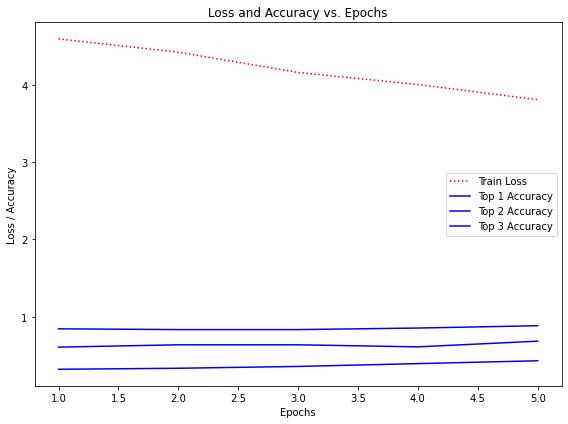

In [24]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')
    
# model
embedding_net_sym = EmbeddingNet_Sym()
model_sym = embedding_net_sym.to(device)

# margin value
margin=1

# criterion
criterion_sym = TripletLoss(margin, Informative_Negative_TripletSelector(margin))

# optimizer
optimizer = torch.optim.SGD(model_sym.parameters(), lr=0.0001, momentum=0.9)

# trainer
trainer = Trainer(model=model_sym,
                  device=device,
                  criterion=criterion_sym,
                  optimizer=optimizer,
                  training_DataLoader=triplets_train_loader,
                  epochs=5)

# start training
trainer.run_trainer()